convert zarr into hestdata format 

In [1]:
import spatialdata as sd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
from anndata import AnnData
from typing import Optional
from pathlib import Path
from hest import XeniumReader
import cv2

import hest
import dask

from hest.readers import pool_transcripts_xenium
from hest.HESTData import XeniumHESTData

from cucim import CuImage

from spatialdata.transformations import (
    Scale,
    get_transformation,
)


In [2]:
# Save original function
original_calc_qc = sc.pp.calculate_qc_metrics

def patched_calc_qc(adata, *args, **kwargs):
    # Limit percent_top to the number of genes
    n_genes = adata.shape[1]
    if 'percent_top' in kwargs:
        kwargs['percent_top'] = [p for p in kwargs['percent_top'] if p <= n_genes]
    else:
        kwargs['percent_top'] = [p for p in (50,100,200,500) if p <= n_genes]
    return original_calc_qc(adata, *args, **kwargs)

sc.pp.calculate_qc_metrics = patched_calc_qc

In [3]:
class SpatialDataXeniumReader:
    """
    Reader for Xenium SpatialData Zarr datasets (e.g., layer 'anucleus').
    Produces a XeniumHESTData object compatible with existing pipelines.
    """

    def __init__(self):
        from hest.readers import XeniumReader  # reuse utilities
        self.reader = XeniumReader()

    def read(
        self,
        zarr_path: str,
        molecule_layer: str = "anucleus",
        spot_size_um: float = 100.0,
        load_img: bool = True,
    ):
        import scanpy as sc
        import pandas as pd
        import numpy as np
        import cv2

        # --- Step 1: Load SpatialData Zarr ---
        print("Loading SpatialData from:", zarr_path)
        sdata = sd.read_zarr(zarr_path)
        print("Available images:", list(sdata.images.keys()))

        # --- Step 2: Extract transcript layer ---
        adata_layer = sdata[molecule_layer].copy()
        print("adata_layer.shape:", adata_layer.shape)
        print("adata_layer.var keys:", adata_layer.var.keys())
        print("adata_layer.obsm keys:", adata_layer.obsm.keys())

        coords = adata_layer.obsm['spatial']
        genes = adata_layer.var['gene_symbols'].values

        # --- Step 3: Build transcript dataframe ---
        df_transcripts = []
        for gi, g in enumerate(genes):
            # if X is sparse, convert; else just use numpy
            col = adata_layer.X[:, gi]
            if hasattr(col, "toarray"):
                col = col.toarray().flatten()
            else:
                col = np.array(col).flatten()
            
            nonzero_idx = np.where(col > 0)[0]
            if len(nonzero_idx) > 0:
                df = pd.DataFrame({
                    "feature_name": g,
                    "x_location": coords[nonzero_idx, 0],
                    "y_location": coords[nonzero_idx, 1],
                })
                df_transcripts.append(df)
        
        df_transcripts = pd.concat(df_transcripts, ignore_index=True)
        print("Transcripts dataframe shape:", df_transcripts.shape)
        print("Transcript preview:\n", df_transcripts.head())

        # Map to H&E coordinates (dummy, since no alignment)
        df_transcripts['he_x'] = df_transcripts['x_location']
        df_transcripts['he_y'] = df_transcripts['y_location']
        df_transcripts['dapi_x'] = df_transcripts['he_x']
        df_transcripts['dapi_y'] = df_transcripts['he_y']

        # --- Step 4: Load image (optional) ---
        downscaled = None
        if load_img and len(sdata.images) > 0:
            img_layer_name = "HE_original"  # explicitly select HE_original
            img = sdata.images[img_layer_name].to_numpy()

            # Ensure (H, W, C)
            if img.ndim == 3 and img.shape[0] <= 4:
                img = np.moveaxis(img, 0, -1)

            # Downscale for visualization
            scale = 0.01
            new_w = max(1, int(img.shape[1] * scale))
            new_h = max(1, int(img.shape[0] * scale))

            # If uint32 -> normalize to uint8
            if img.dtype == np.uint32:
                img = (img.astype(np.float32) / img.max()) * 255
                img = img.astype(np.uint8)

            downscaled = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # --- Step 5: Estimate pixel size ---
        if load_img and len(sdata.images) > 0:
            pixel_size_estimated = getattr(sdata.images[img_layer_name], "pixel_size", 0.2125)
        else:
            img = None
            pixel_size_estimated = 0.2125
        print("Pixel size (um/px):", pixel_size_estimated)

        # --- Step 6: Pool transcripts to pseudo-Visium spots ---
        adata = pool_transcripts_xenium(df_transcripts, pixel_size_estimated, spot_size_um=spot_size_um)
        print("Pooled AnnData shape:", adata.shape)
        print("AnnData obs columns:", adata.obs.columns)
        print("AnnData var names (first 10):", adata.var_names[:10])
        print("AnnData obsm keys:", adata.obsm.keys())

        # Attach downscaled image
        adata.uns["spatial"] = {"ST": {"images": {"downscaled_fullres": downscaled}}}
        
        # assume spot_size_um in um, pixel_size_estimated in um/px
        spot_diameter_px = spot_size_um / pixel_size_estimated
        print("spot_size_um: ",spot_size_um)
        print("spot_diameter_px: ",spot_diameter_px)

        adata.uns["spatial"]["ST"] = {
            "images": {
                "downscaled_fullres": downscaled,  # required by HEST
                #"hires": downscaled,               # required by Scanpy
                #"lowres": downscaled,              # optional, can duplicate hires
            },
            "scalefactors": {
                "spot_diameter_fullres": spot_diameter_px,
                "tissue_downscaled_fullres_scalef": scale,
            },
        }
        # --- Step 7: Return HEST object ---
        st_object = XeniumHESTData(
            adata=adata,
            img=img,
            pixel_size=pixel_size_estimated,
            meta={},
            shapes=[],
            xenium_nuc_seg=None,
            xenium_cell_seg=None,
            cell_adata=None,
            transcript_df=df_transcripts,
            dapi_path=None,
            alignment_file_path=None
        )

        print("HESTData object created successfully")
        return st_object


In [4]:
zarr_path = '/project/simmons_hts/kxu/JupyterFolder/broadchallenge/data/UC9_I.zarr'

# Initialize reader
sdata_reader = SpatialDataXeniumReader()

# Read Zarr into XeniumHESTData
xenium_data = sdata_reader.read(
    zarr_path=zarr_path,
    molecule_layer="anucleus",  # layer containing transcripts
    spot_size_um=100.0,
    load_img=True,
    
)


Loading SpatialData from: /project/simmons_hts/kxu/JupyterFolder/broadchallenge/data/UC9_I.zarr


/package/python-cbrg/current/3.11.3/lib/python3.11/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Available images: ['HE_nuc_original', 'HE_original']
adata_layer.shape: (196937, 460)
adata_layer.var keys: Index(['gene_symbols'], dtype='object')
adata_layer.obsm keys: KeysView(AxisArrays with keys: spatial)
Transcripts dataframe shape: (5554515, 3)
Transcript preview:
   feature_name    x_location   y_location
0          A2M   9252.387970  4270.654135
1          A2M   9453.282443  4406.570992
2          A2M  11549.007680  3512.689708
3          A2M   9438.882102  4426.477273
4          A2M   9585.633891  4380.822176
Pixel size (um/px): 0.2125
Pooled AnnData shape: (7630, 460)
AnnData obs columns: Index(['in_tissue', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'array_col',
       'array_row', 'n_counts'],
      dtype='object')
AnnData var names (first 10): Index(['A2M', 'ACP5', 'ACTA2', 'ADAMTSL3', 'AFAP1L2', 'AHR', 'ALDH1B1', 'ANO1',
       'ANXA1', 'AQP1'],
      dtype='object')
AnnData obsm keys: KeysView(AxisArrays with keys: spatial)
spot_size_um:  100.0
spot_diameter_px:  470.

/package/python-cbrg/current/3.11.3/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [5]:
xenium_data

# ST (adata):
adata = xenium_data.adata
print('\n* Scanpy adata:')
print(adata)

# WSI:
wsi = xenium_data.wsi
print('\n* WSI:')
print(wsi)

# Shapes:
shapes = xenium_data.shapes
print('\n* Shapes:')
print(shapes)



* Scanpy adata:
AnnData object with n_obs × n_vars = 7630 × 460
    obs: 'in_tissue', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'array_col', 'array_row', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

* WSI:
<width=21000, height=20000, backend=NumpyWSI>

* Shapes:
[]


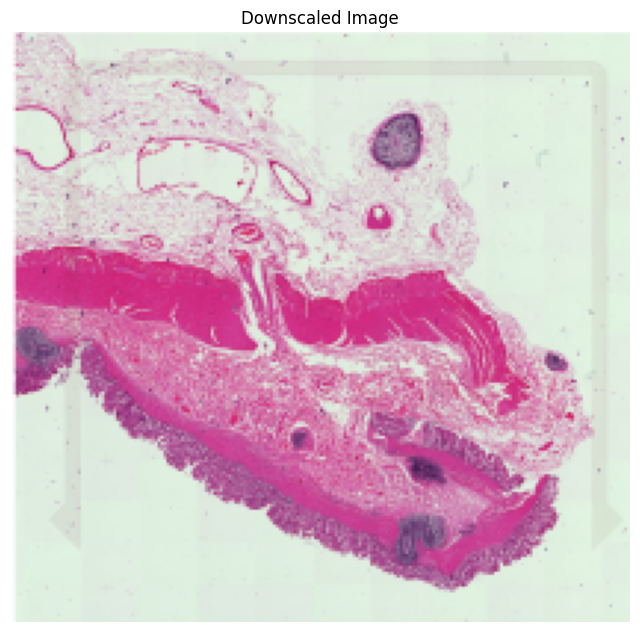

In [6]:
import matplotlib.pyplot as plt

# Extract the downscaled image
downscaled_img = xenium_data.adata.uns['spatial']['ST']['images']['downscaled_fullres']

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(downscaled_img)
plt.axis('off')
plt.title("Downscaled Image")
plt.show()

/home/k/kxu/.local/lib/python3.11/site-packages/hest/HESTData.py:1390: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  fig = sc.pl.spatial(adata, show=False, img_key="downscaled_fullres", color=[key], title=f"in_tissue spots", return_fig=True, **pl_kwargs)


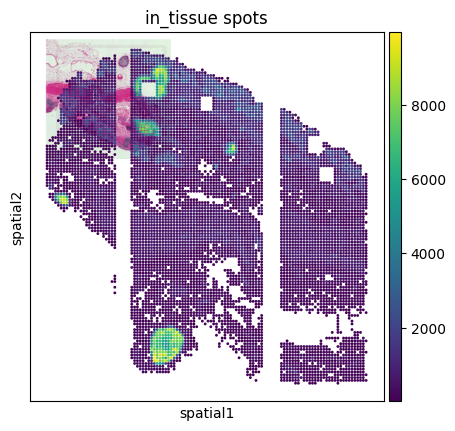

In [48]:
# visualize the spots over a downscaled version of the full resolution image
save_dir = Path("/project/simmons_hts/kxu/hest/xenium_data/broad/UC9_I")
# create directory (recursively) if it doesn't exist
save_dir.mkdir(parents=True, exist_ok=True)
xenium_data.save_spatial_plot(save_dir)

# step by step breakdown

In [7]:
import spatialdata as sd

# Load the Zarr folder
sdata = sd.read_zarr(zarr_path)
print(sdata)
# Inspect the top-level structure

print("\nImages available:")
print(list(sdata.images.keys()))

SpatialData object, with associated Zarr store: /ceph/project/simmons_hts/kxu/JupyterFolder/broadchallenge/data/UC9_I.zarr
├── Images
│     ├── 'HE_nuc_original': DataArray[cyx] (1, 20000, 21000)
│     └── 'HE_original': DataArray[cyx] (3, 20000, 21000)
└── Tables
      ├── 'anucleus': AnnData (196937, 460)
      └── 'cell_id-group': AnnData (244527, 0)
with coordinate systems:
    ▸ 'global', with elements:
        HE_nuc_original (Images), HE_original (Images)

Images available:
['HE_nuc_original', 'HE_original']


/package/python-cbrg/current/3.11.3/lib/python3.11/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
print("\nAvailable points:")
print(list(sdata.points.keys()))  # might be empty in minimal version

print("\nCoordinate systems:")
print(sdata.coordinate_systems)


Available points:
[]

Coordinate systems:
['global']



Anucleus AnnData:
AnnData object with n_obs × n_vars = 196937 × 460
    obs: 'cell_id'
    var: 'gene_symbols'
    obsm: 'spatial'
    layers: 'counts'
Obs (cells):     cell_id
48       48
51       51
56       56
59       59
66       66
Var (features):          gene_symbols
A2M               A2M
ACP5             ACP5
ACTA2           ACTA2
ADAMTSL3     ADAMTSL3
AFAP1L2       AFAP1L2
Layers: ['counts']
Obsm: ['spatial']

Spatial coordinates shape: (196937, 2)


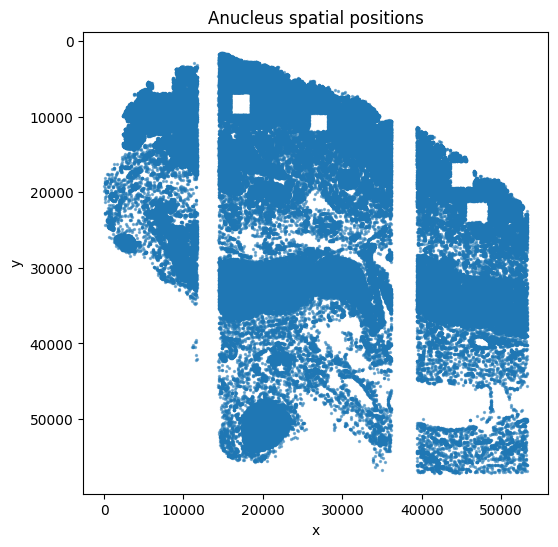


cell_id-group AnnData:
AnnData object with n_obs × n_vars = 244527 × 0
    obs: 'cell_id', 'group'
    cell_id  group
2        48  train
4        51  train
8        56  train
11       59  train
16       66  train


In [18]:
# --- Inspect AnnData Tables ---
anucleus: AnnData = sdata.tables["anucleus"]
print("\nAnucleus AnnData:")
print(anucleus)

print("Obs (cells):", anucleus.obs.head())
print("Var (features):", anucleus.var.head())
print("Layers:", list(anucleus.layers.keys()))
print("Obsm:", list(anucleus.obsm.keys()))

# Explore spatial coordinates
if "spatial" in anucleus.obsm:
    spatial_coords = anucleus.obsm["spatial"]
    print("\nSpatial coordinates shape:", spatial_coords.shape)
    
    # quick scatter plot of nuclei positions
    plt.figure(figsize=(6,6))
    plt.scatter(spatial_coords[:,0], spatial_coords[:,1], s=2, alpha=0.5)
    plt.title("Anucleus spatial positions")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().invert_yaxis()  # match image convention
    plt.show()

# --- Inspect cell_id-group mapping ---
cell_group: AnnData = sdata.tables["cell_id-group"]
print("\ncell_id-group AnnData:")
print(cell_group)
print(cell_group.obs.head())

In [8]:
# Pick the molecule layer (e.g., "anucleus")
molecule_layer = "anucleus"
adata_layer = sdata[molecule_layer]

# Inspect AnnData structure
print("\nAnnData for layer", molecule_layer)
print(adata_layer)

print("\n.obs columns (cell metadata):")
print(adata_layer.obs.columns)

print("\n.var columns (gene metadata):")
print(adata_layer.var.columns)

print("\n.obsm keys (spatial coordinates):")
print(adata_layer.obsm.keys())

print("\nNumber of cells:", adata_layer.n_obs)
print("Number of genes:", adata_layer.n_vars)


AnnData for layer anucleus
AnnData object with n_obs × n_vars = 196937 × 460
    obs: 'cell_id'
    var: 'gene_symbols'
    obsm: 'spatial'
    layers: 'counts'

.obs columns (cell metadata):
Index(['cell_id'], dtype='object')

.var columns (gene metadata):
Index(['gene_symbols'], dtype='object')

.obsm keys (spatial coordinates):
KeysView(AxisArrays with keys: spatial)

Number of cells: 196937
Number of genes: 460


In [9]:
adata_layer.obs

,cell_id
48,48
51,51
56,56
59,59
66,66
...,...
326465,326465
326474,326474
326478,326478
326481,326481


In [6]:
# For each transcript, get gene name and spatial position
df_transcripts = pd.DataFrame({
    'feature_name': np.repeat(adata_layer.var['gene_symbols'].values, adata_layer.n_obs),
    'x_location': np.tile(adata_layer.obsm['spatial'][:, 0], adata_layer.n_vars),
    'y_location': np.tile(adata_layer.obsm['spatial'][:, 1], adata_layer.n_vars)
})

# Inspect first rows
print("\nFirst 10 transcripts:")
print(df_transcripts.head())

# Check size
print("Total transcripts:", df_transcripts.shape[0])


First 10 transcripts:
  feature_name    x_location   y_location
0          A2M  11441.644760  3835.278863
1          A2M   9252.387970  4270.654135
2          A2M  11402.793860  3879.355263
3          A2M   9453.282443  4406.570992
4          A2M   9418.438776  3991.557823
Total transcripts: 90591020


In [7]:
# Pick the first image layer
img_layer_name = list(sdata.images.keys())[0]
img_data = sdata.images[img_layer_name].data

# Inspect type and shape
print("\nImage type:", type(img_data))
print("Image shape:", img_data.shape)

# If it's a Dask array, compute a small slice
if "dask.array" in str(type(img_data)):
    print("Preview of image (small slice):")
    print(img_data[0:1, 0:100, 0:100].compute())
    
img_layer = sdata.images[img_layer_name]
print(img_layer.attrs)   # Check attributes


Image type: <class 'dask.array.core.Array'>
Image shape: (1, 20000, 21000)
Preview of image (small slice):
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
{'transform': {'global': Identity }}


In [8]:
from hest.readers import pool_transcripts_xenium

# Determine pixel size
pixel_size_estimated = getattr(sdata.images[img_layer_name], "pixel_size", 0.2125)
print('pixel size:', pixel_size_estimated)

# Pool transcripts
df_transcripts['he_x'] = df_transcripts['x_location']
df_transcripts['he_y'] = df_transcripts['y_location']
adata_pooled = pool_transcripts_xenium(df_transcripts, pixel_size_estimated, spot_size_um=100.0)

# Inspect pooled AnnData
print("\nPooled AnnData:")
print(adata_pooled)

print("\nSpatial coordinates (pooled spots):")
print(adata_pooled.obsm['spatial'][:10])

print("\nExpression matrix shape:", adata_pooled.X.shape)

pixel size: 0.2125

Pooled AnnData:
AnnData object with n_obs × n_vars = 7630 × 460
    obs: 'in_tissue', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'array_col', 'array_row', 'n_counts'
    obsm: 'spatial'

Spatial coordinates (pooled spots):
[[14380.07410698  1779.17487645]
 [14850.66234228  1779.17487645]
 [15321.25057757  1779.17487645]
 [15791.83881287  1779.17487645]
 [14380.07410698  2249.76311175]
 [14850.66234228  2249.76311175]
 [15321.25057757  2249.76311175]
 [15791.83881287  2249.76311175]
 [16262.42704816  2249.76311175]
 [16733.01528345  2249.76311175]]

Expression matrix shape: (7630, 460)


/package/python-cbrg/current/3.11.3/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [9]:
print("Raw transcript coordinates (first 10):")
print(df_transcripts[['he_x', 'he_y']].head())

print("Pooled spot coordinates (first 10):")
print(adata_pooled.obsm['spatial'][:10])

Raw transcript coordinates (first 10):
           he_x         he_y
0  11441.644760  3835.278863
1   9252.387970  4270.654135
2  11402.793860  3879.355263
3   9453.282443  4406.570992
4   9418.438776  3991.557823
Pooled spot coordinates (first 10):
[[14380.07410698  1779.17487645]
 [14850.66234228  1779.17487645]
 [15321.25057757  1779.17487645]
 [15791.83881287  1779.17487645]
 [14380.07410698  2249.76311175]
 [14850.66234228  2249.76311175]
 [15321.25057757  2249.76311175]
 [15791.83881287  2249.76311175]
 [16262.42704816  2249.76311175]
 [16733.01528345  2249.76311175]]


In [10]:
# List available images
print(sdata.images.keys())
print("HE_original shape:", sdata.images["HE_original"].shape)

KeysView({'HE_nuc_original': <xarray.DataArray 'image' (c: 1, y: 20000, x: 21000)> Size: 2GB
dask.array<from-zarr, shape=(1, 20000, 21000), dtype=uint32, chunksize=(1, 5792, 5792), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 8B 0
  * y        (y) float64 160kB 0.5 1.5 2.5 3.5 4.5 ... 2e+04 2e+04 2e+04 2e+04
  * x        (x) float64 168kB 0.5 1.5 2.5 3.5 ... 2.1e+04 2.1e+04 2.1e+04
Attributes:
    transform:  {'global': Identity }, 'HE_original': <xarray.DataArray 'image' (c: 3, y: 20000, x: 21000)> Size: 1GB
dask.array<from-zarr, shape=(3, 20000, 21000), dtype=uint8, chunksize=(3, 6688, 6688), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 24B 0 1 2
  * y        (y) float64 160kB 0.5 1.5 2.5 3.5 4.5 ... 2e+04 2e+04 2e+04 2e+04
  * x        (x) float64 168kB 0.5 1.5 2.5 3.5 ... 2.1e+04 2.1e+04 2.1e+04
Attributes:
    transform:  {'global': Identity }})
HE_original shape: (3, 20000, 21000)


In [27]:
# sdata = sd.read_zarr('/project/simmons_hts/kxu/JupyterFolder/broadchallenge/data/UC7_I.zarr')
# print(sdata)
# print(sdata.coordinate_systems)

SpatialData object, with associated Zarr store: /ceph/project/simmons_hts/kxu/JupyterFolder/broadchallenge/data/UC7_I.zarr
├── Images
│     ├── 'HE_nuc_original': DataArray[cyx] (1, 17000, 20992)
│     └── 'HE_original': DataArray[cyx] (3, 17000, 20992)
└── Tables
      ├── 'anucleus': AnnData (144704, 460)
      └── 'cell_id-group': AnnData (277046, 0)
with coordinate systems:
    ▸ 'global', with elements:
        HE_nuc_original (Images), HE_original (Images)
['global']


/package/python-cbrg/current/3.11.3/lib/python3.11/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
# Extract original image from SpatialData
img = sdata.images["HE_original"].to_numpy()  
img = np.moveaxis(img, 0, -1)  # (C,H,W) → (H,W,C)
print("Shape of img:", img.shape, img.dtype)

# Downscale for visualization (optional, speeds things up)
scale = 0.1   # 10% size, adjust as needed
downscaled = cv2.resize(
    img, 
    (int(img.shape[1] * scale), int(img.shape[0] * scale)),
    interpolation=cv2.INTER_AREA
)


Shape of img: (20000, 21000, 3) uint8


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Get original image
img = sdata.images["HE_original"].to_numpy()

# If image is in (C, H, W), move channels to last axis
if img.ndim == 3 and img.shape[0] <= 4:  # assume <=4 channels
    img = np.moveaxis(img, 0, -1)

# Downscale for plotting (optional, avoids huge display)
scale = 0.1
new_w = max(1, int(img.shape[1] * scale))
new_h = max(1, int(img.shape[0] * scale))

import cv2
downscaled = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

# Plot
plt.figure(figsize=(10, 10))
plt.imshow(downscaled)
plt.axis("off")
plt.title("HE_original (downscaled for visualization)")
plt.show()

# import large spatialdata

## unzip (only need to run once)

In [24]:
# import os
# import zipfile

# # Path where the .zarr.large.zip files live
# base_dir = "/ceph/project/simmons_hts/kxu/hest/data/broad"

# # Output folder for extracted zarr datasets
# output_dir = os.path.join(base_dir, "zarr")
# os.makedirs(output_dir, exist_ok=True)

# # Find all zip files
# zip_files = [f for f in os.listdir(base_dir) if f.endswith(".zarr.large.zip")]

# print(f"Found {len(zip_files)} zip files")

# for zf in zip_files:
#     zip_path = os.path.join(base_dir, zf)
#     dataset_name = zf.replace(".large.zip", "")  # e.g. UC9_I.zarr
#     extract_path = os.path.join(output_dir)      # <- only parent

#     expected_path = os.path.join(output_dir, dataset_name)
#     if os.path.exists(expected_path):
#         print(f"⚠️ Skipping {zf} (already extracted at {expected_path})")
#         continue

#     print(f"📦 Extracting {zf} → {output_dir}")
#     with zipfile.ZipFile(zip_path, "r") as zip_ref:
#         zip_ref.extractall(extract_path)

# print("✅ All .zarr.large.zip files extracted into:", output_dir)

Found 8 zip files
📦 Extracting DC1.zarr.large.zip → /ceph/project/simmons_hts/kxu/hest/data/broad/zarr
📦 Extracting UC6_I.zarr.large.zip → /ceph/project/simmons_hts/kxu/hest/data/broad/zarr
📦 Extracting UC1_I.zarr.large.zip → /ceph/project/simmons_hts/kxu/hest/data/broad/zarr
📦 Extracting UC1_NI.zarr.large.zip → /ceph/project/simmons_hts/kxu/hest/data/broad/zarr
📦 Extracting DC5.zarr.large.zip → /ceph/project/simmons_hts/kxu/hest/data/broad/zarr
📦 Extracting UC9_I.zarr.large.zip → /ceph/project/simmons_hts/kxu/hest/data/broad/zarr
📦 Extracting UC6_NI.zarr.large.zip → /ceph/project/simmons_hts/kxu/hest/data/broad/zarr
📦 Extracting UC7_I.zarr.large.zip → /ceph/project/simmons_hts/kxu/hest/data/broad/zarr
✅ All .zarr.large.zip files extracted into: /ceph/project/simmons_hts/kxu/hest/data/broad/zarr


## import zarr

### read UC1_NI

In [4]:
import os
# --- 2. Load SpatialData from Zarr ---
# Replace <dataset_name> with the actual folder name inside zarr_data
base_dir = "/project/simmons_hts/kxu/hest/data/broad"
output_dir = os.path.join(base_dir, "zarr")

dataset_path = os.path.join(output_dir, "UC1_NI.zarr")
sdata_large = sd.read_zarr(dataset_path)
print(sdata_large)

SpatialData object, with associated Zarr store: /ceph/project/simmons_hts/kxu/hest/data/broad/zarr/UC1_NI.zarr
├── Images
│     ├── 'DAPI': DataArray[cyx] (1, 51060, 53998)
│     ├── 'DAPI_nuc': DataArray[cyx] (1, 51060, 53998)
│     ├── 'HE_nuc_original': DataArray[cyx] (1, 21000, 22000)
│     ├── 'HE_nuc_registered': DataArray[cyx] (1, 51060, 53998)
│     ├── 'HE_original': DataArray[cyx] (3, 21000, 22000)
│     ├── 'HE_registered': DataArray[cyx] (3, 51060, 53998)
│     ├── 'group': DataArray[cyx] (1, 51060, 53998)
│     └── 'group_HEspace': DataArray[cyx] (1, 21000, 22000)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 8) (2D points)
└── Tables
      ├── 'anucleus': AnnData (80037, 460)
      └── 'cell_id-group': AnnData (93686, 0)
with coordinate systems:
    ▸ 'global', with elements:
        DAPI (Images), DAPI_nuc (Images), HE_nuc_original (Images), HE_nuc_registered (Images), HE_original (Images), HE_registered (Images), group (Images), group_HEspace (Im

/package/python-cbrg/current/3.11.3/lib/python3.11/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [12]:
sdata_large["cell_id-group"].obs['group'].value_counts()

group
train         80037
test           7474
validation     6175
Name: count, dtype: int64

### read UC1_I

In [15]:
import os
# --- 2. Load SpatialData from Zarr ---
# Replace <dataset_name> with the actual folder name inside zarr_data
base_dir = "/project/simmons_hts/kxu/hest/data/broad"
output_dir = os.path.join(base_dir, "zarr")

dataset_path = os.path.join(output_dir, "UC1_I.zarr")
sdata_large = sd.read_zarr(dataset_path)
print(sdata_large)

SpatialData object, with associated Zarr store: /ceph/project/simmons_hts/kxu/hest/data/broad/zarr/UC1_I.zarr
├── Images
│     ├── 'DAPI': DataArray[cyx] (1, 47659, 51147)
│     ├── 'DAPI_nuc': DataArray[cyx] (1, 47659, 51147)
│     ├── 'HE_nuc_original': DataArray[cyx] (1, 20000, 22000)
│     ├── 'HE_nuc_registered': DataArray[cyx] (1, 47659, 51147)
│     ├── 'HE_original': DataArray[cyx] (3, 20000, 22000)
│     ├── 'HE_registered': DataArray[cyx] (3, 47659, 51147)
│     ├── 'group': DataArray[cyx] (1, 47659, 51147)
│     └── 'group_HEspace': DataArray[cyx] (1, 20000, 22000)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 8) (2D points)
└── Tables
      ├── 'anucleus': AnnData (202534, 460)
      └── 'cell_id-group': AnnData (234356, 0)
with coordinate systems:
    ▸ 'global', with elements:
        DAPI (Images), DAPI_nuc (Images), HE_nuc_original (Images), HE_nuc_registered (Images), HE_original (Images), HE_registered (Images), group (Images), group_HEspace (I

/package/python-cbrg/current/3.11.3/lib/python3.11/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [16]:
sdata_large["cell_id-group"].obs['group'].value_counts()

group
train         202534
test           17374
validation     14448
Name: count, dtype: int64

### read UC9_I

In [13]:
import os
# --- 2. Load SpatialData from Zarr ---
# Replace <dataset_name> with the actual folder name inside zarr_data
base_dir = "/project/simmons_hts/kxu/hest/data/broad"
output_dir = os.path.join(base_dir, "zarr")

dataset_path = os.path.join(output_dir, "UC9_I.zarr")
sdata_large = sd.read_zarr(dataset_path)
print(sdata_large)

SpatialData object, with associated Zarr store: /ceph/project/simmons_hts/kxu/hest/data/broad/zarr/UC9_I.zarr
├── Images
│     ├── 'DAPI': DataArray[cyx] (1, 57853, 53986)
│     ├── 'DAPI_nuc': DataArray[cyx] (1, 57853, 53986)
│     ├── 'HE_nuc_original': DataArray[cyx] (1, 20000, 21000)
│     ├── 'HE_nuc_registered': DataArray[cyx] (1, 57853, 53986)
│     ├── 'HE_original': DataArray[cyx] (3, 20000, 21000)
│     ├── 'HE_registered': DataArray[cyx] (3, 57853, 53986)
│     ├── 'group': DataArray[cyx] (1, 57853, 53986)
│     └── 'group_HEspace': DataArray[cyx] (1, 20000, 21000)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 8) (2D points)
└── Tables
      ├── 'anucleus': AnnData (196937, 460)
      └── 'cell_id-group': AnnData (244527, 0)
with coordinate systems:
    ▸ 'global', with elements:
        DAPI (Images), DAPI_nuc (Images), HE_nuc_original (Images), HE_nuc_registered (Images), HE_original (Images), HE_registered (Images), group (Images), group_HEspace (I

/package/python-cbrg/current/3.11.3/lib/python3.11/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [14]:
sdata_large["cell_id-group"].obs['group'].value_counts()

group
train         196937
validation     27662
test           19928
Name: count, dtype: int64

In [13]:
sdata_large['HE_registered']

<xarray.DataArray 'image' (c: 3, y: 57853, x: 53986)> Size: 9GB
dask.array<from-zarr, shape=(3, 57853, 53986), dtype=uint8, chunksize=(3, 6688, 6688), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 24B 0 1 2
  * y        (y) float64 463kB 0.5 1.5 2.5 3.5 ... 5.785e+04 5.785e+04 5.785e+04
  * x        (x) float64 432kB 0.5 1.5 2.5 3.5 ... 5.398e+04 5.398e+04 5.399e+04
Attributes:
    transform:  {'global': Identity }

In [14]:
sdata_large['HE_original']

<xarray.DataArray 'image' (c: 3, y: 20000, x: 21000)> Size: 1GB
dask.array<from-zarr, shape=(3, 20000, 21000), dtype=uint8, chunksize=(3, 6688, 6688), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 24B 0 1 2
  * y        (y) float64 160kB 0.5 1.5 2.5 3.5 4.5 ... 2e+04 2e+04 2e+04 2e+04
  * x        (x) float64 168kB 0.5 1.5 2.5 3.5 ... 2.1e+04 2.1e+04 2.1e+04
Attributes:
    transform:  {'global': Identity }

In [23]:
print(sdata_large["anucleus"])

print(sdata_large["anucleus"].obs.head())
print(sdata_large["anucleus"].var.head())

# Check the shape of the spatial coordinates
print(sdata_large["anucleus"].obsm['spatial'].shape)
print(sdata_large["anucleus"].obsm['spatial'][:5])  # first 5 coordinates

# Check the counts matrix layer
print(sdata_large["anucleus"].layers['counts'].shape)

anucleus = sdata_large["anucleus"].obsm['spatial']

x_min, x_max = np.min(anucleus[:,0]), np.max(anucleus[:,0])
y_min, y_max = np.min(anucleus[:,1]), np.max(anucleus[:,1])

print("x range:", x_min, "→", x_max)
print("y range:", y_min, "→", y_max)

AnnData object with n_obs × n_vars = 196937 × 460
    obs: 'cell_id'
    var: 'gene_symbols'
    obsm: 'spatial'
    layers: 'counts'
    cell_id
48       48
51       51
56       56
59       59
66       66
         gene_symbols
A2M               A2M
ACP5             ACP5
ACTA2           ACTA2
ADAMTSL3     ADAMTSL3
AFAP1L2       AFAP1L2
(196937, 2)
[[11441.64476021  3835.27886323]
 [ 9252.38796992  4270.65413534]
 [11402.79385965  3879.35526316]
 [ 9453.28244275  4406.57099237]
 [ 9418.43877551  3991.55782313]]
(196937, 460)
x range: 27.132930513595166 → 53255.36680911681
y range: 1543.880758807588 → 57099.993256262045


In [16]:
df_cells = pd.DataFrame(sdata_large["anucleus"].obsm['spatial'])
df_cells.set_index(sdata_large["anucleus"].obs_names, inplace=True)
df_cells

,0,1
48,11441.644760,3835.278863
51,9252.387970,4270.654135
56,11402.793860,3879.355263
59,9453.282443,4406.570992
66,9418.438776,3991.557823
...,...,...
326465,53043.791766,56161.975455
326474,50255.422111,54362.000000
326478,50524.748848,54499.511521
326481,52900.012048,55648.849398


In [17]:
sdata_large["cell_id-group"]
print(sdata_large["cell_id-group"].obs.head())

    cell_id  group
2        48  train
4        51  train
8        56  train
11       59  train
16       66  train


In [18]:
sdata_large.points['transcripts']

,x,y,qv,cell_id,feature_name,region,z_location,transcript_id
npartitions=8,,,,,,,,
,float64,float64,float64,int64,string,int64,float64,int64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


In [19]:
transcripts = sdata_large.points["transcripts"]

# Use Dask's describe (lazy compute)
print(transcripts[["x", "y"]].describe().compute())

# Or explicitly get min/max
x_min = transcripts["x"].min().compute()
x_max = transcripts["x"].max().compute()
y_min = transcripts["y"].min().compute()
y_max = transcripts["y"].max().compute()

print("x range:", x_min, "→", x_max)
print("y range:", y_min, "→", y_max)

                  x             y
count  4.223277e+07  4.223277e+07
mean   5.711620e+03  5.544344e+03
std    2.864010e+03  3.091517e+03
min    1.848735e+00  1.066761e+00
25%    3.910003e+03  3.733390e+03
50%    5.249964e+03  6.646803e+03
75%    7.749305e+03  1.054844e+04
max    1.147145e+04  1.229152e+04
x range: 1.8487349 → 11471.45
y range: 1.0667608 → 12291.524


In [21]:
x_max * pixel_size

53983.29411764706

In [20]:
pixel_size = get_transformation(sdata_large["transcripts"], to_coordinate_system='scale_um_to_px').scale[0]
print("pixel size: ", pixel_size)

pixel size:  4.705882352941177


This is the pixel size conversion for scale_um_to_px (not clear for HE_registered or HE_original): pixel size:  4.705882352941177

# Read Large Zarr file as HESTData

anucleus spatial is already in the HE_registered coordinates

transcripts coordinates are not, they need to time the pixel_size *scale_um_to_px to be in that system 

In [2]:
import spatialdata as sd
import tifffile
import numpy as np
import scanpy as sc
from pathlib import Path
from hest.HESTData import XeniumHESTData
from hest.utils import register_downscale_img
from hest.readers import pool_transcripts_xenium
from spatialdata import SpatialData
from hestcore.wsi import wsi_factory

def read_xenium_zarr(zarr_path: str, spot_size_um: float = 100.0) -> XeniumHESTData:
    """
    Read a Xenium Zarr sample and create a HESTData object.
    
    Args:
        zarr_path (str): path to Zarr store
        spot_size_um (float): size of pseudo-visium pooling spots in um
        
    Returns:
        XeniumHESTData: pooled and spatially ready Xenium object
    """
    # --- Load the Zarr ---
    sdata = sd.read_zarr(zarr_path)
    
    # --- Load transcript table ---
    # 'transcripts' is a SpatialData Points object; convert to pandas
    transcripts = sdata.points['transcripts'].compute() if hasattr(sdata.points['transcripts'], 'compute') else sdata.points['transcripts']
    transcripts = pd.DataFrame(transcripts)  # ensure pandas DataFrame
    
    # --- Pool transcripts into pseudo-visium spots ---
    scale_um_to_px = get_transformation(sdata["transcripts"], to_coordinate_system='scale_um_to_px').scale[0] # unit is px/um, as it converts um of transcripts to px of image
    pixel_size = 1 / scale_um_to_px # 0.2125
    
    print("pixel size: ", pixel_size)
    
    # Expected columns: ['feature_name', 'x', 'y', ...]; rename to match pooling function
    transcripts['he_x'] = transcripts['x'] / pixel_size
    transcripts['he_y'] = transcripts['y'] / pixel_size
    
    # --- Pool transcripts into pseudo-visium spots ---
    adata = pool_transcripts_xenium(
        transcripts,
        pixel_size_he=pixel_size,
        spot_size_um=spot_size_um,
        key_x='he_x',
        key_y='he_y'
    )
    
    # --- Load HE_registered image and downscale ---
    img = np.array(sdata.images['HE_registered']).transpose(1, 2, 0)  # (H, W, C)
    img, pixel_size_embedded = wsi_factory(img), None
    register_downscale_img(adata, img,pixel_size)
                           # spot_size = spot_size_um (Original Hest XeniumReader does not have that and default to 55; technically it should be 100)
    
    # create metadata 
    dict = {}
    dict['pixel_size_um_embedded']=pixel_size_embedded
    dict['pixel_size_um_estimated']=pixel_size
    dict['spot_diameter'] = spot_size_um
    dict['inter_spot_dist'] = spot_size_um
    dict['spots_under_tissue'] = len(adata.obs)
    dict['tissue_downscaled_fullres_scalef'] = adata.uns['spatial']['ST']['scalefactors']['tissue_downscaled_fullres_scalef']
    dict['spot_diameter_fullres'] = adata.uns['spatial']['ST']['scalefactors']['spot_diameter_fullres']

    # --- Optional: keep DAPI path if available ---
    dapi_path = None
    if 'DAPI' in sdata.images:
        dapi_path = sdata.images['DAPI']
    
    # --- Cell-level AnnData if available ---
    cell_adata = None
    if 'anucleus' in sdata.tables:
        cell_adata = sdata.tables['anucleus']
        # cell_adata.obsm["spatial"] = cell_adata.obsm["spatial"] / pixel_size # already in the HE_registered coordinates so no need to scale
        dict['cells_under_tissue'] = len(cell_adata.obs)
    
    # --- Build HESTData object ---
    st_object = XeniumHESTData(
        adata=adata,
        img=img,
        pixel_size=pixel_size,
        meta=dict,
        transcript_df=transcripts,
        cell_adata=cell_adata,
        dapi_path=dapi_path
    )
    
    return st_object

In [3]:
zarr_path = "/project/simmons_hts/kxu/hest/data/broad/zarr/UC6_I.zarr"
st = read_xenium_zarr(zarr_path)

/package/python-cbrg/current/3.11.3/lib/python3.11/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


pixel size:  0.2125


/package/python-cbrg/current/3.11.3/lib/python3.11/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [4]:
st

        'pixel_size' is 0.2125
        'wsi' is <width=54010, height=57868, backend=NumpyWSI>
        'shapes': []

In [5]:
# ST (adata):
adata = st.adata
print('\n* Scanpy adata:')
print(adata)

# WSI:
wsi = st.wsi
print('\n* WSI:')
print(wsi)

# Cells:
cells = st.cell_adata
print('\n* Cells:')
print(cells)

# Metadata:
metadata = st.meta
print('\n* Metadata:')
print(metadata)


* Scanpy adata:
AnnData object with n_obs × n_vars = 9354 × 521
    obs: 'in_tissue', 'pxl_col_in_fullres', 'pxl_row_in_fullres', 'array_col', 'array_row', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

* WSI:
<width=54010, height=57868, backend=NumpyWSI>

* Cells:
AnnData object with n_obs × n_vars = 223790 × 460
    obs: 'cell_id'
    var: 'gene_symbols'
    obsm: 'spatial'
    layers: 'counts'

* Metadata:
{'pixel_size_um_embedded': None, 'pixel_size_um_estimated': 0.2125, 'spot_diameter': 100.0, 'inter_spot_dist': 100.0, 'spots_under_tissue': 9354, 'tissue_downscaled_fullres_scalef': 0.017280707817792215, 'spot_diameter_fullres': 258.823529411764

Obs (cells):          in_tissue  pxl_col_in_fullres  pxl_row_in_fullres  array_col  \
000x048       True        22828.481551          245.376894         48   
000x049       True        23299.069786          245.376894         49   
000x050       True        23769.658021          245.376894         50   
000x051       True        24240.246256          245.376894         51   
000x052       True        24710.834492          245.376894         52   

         array_row  n_counts  n_genes_by_counts  log1p_n_genes_by_counts  \
000x048          0        11                  7                 2.079442   
000x049          0        27                 14                 2.708050   
000x050          0        12                  9                 2.302585   
000x051          0        19                 12                 2.564949   
000x052          0        23                 14                 2.708050   

         total_counts  log1p_total_counts  pct_counts_in_top_50_genes  \
000x048           

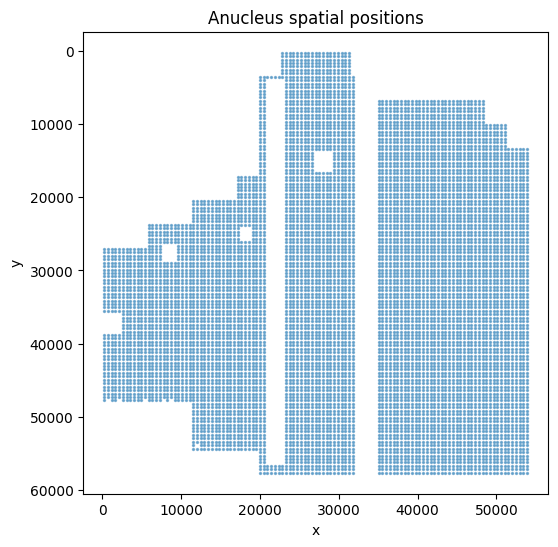

In [6]:
# --- Inspect AnnData Tables ---
print("Obs (cells):", st.adata.obs.head())
print("Var (features):", st.adata.var.head())
print("Layers:", list(st.adata.layers.keys()))
print("Obsm:", list(st.adata.obsm.keys()))

# Explore spatial coordinates
if "spatial" in st.adata.obsm:
    spatial_coords = st.adata.obsm["spatial"]
    print("\nSpatial coordinates shape:", spatial_coords.shape)
    
    # quick scatter plot of nuclei positions
    plt.figure(figsize=(6,6))
    plt.scatter(spatial_coords[:,0], spatial_coords[:,1], s=2, alpha=0.5)
    plt.title("Anucleus spatial positions")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().invert_yaxis()  # match image convention
    plt.show()

/home/k/kxu/.local/lib/python3.11/site-packages/hest/HESTData.py:1390: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  fig = sc.pl.spatial(adata, show=False, img_key="downscaled_fullres", color=[key], title=f"in_tissue spots", return_fig=True, **pl_kwargs)


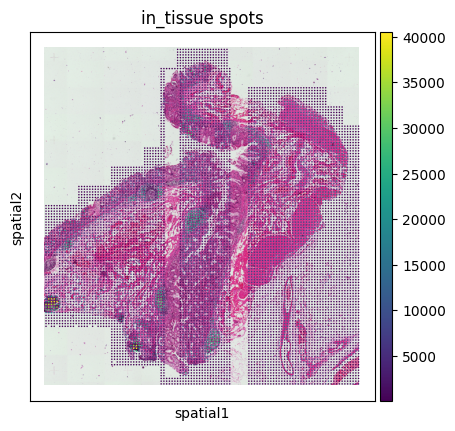

In [7]:
# visualize the spots over a downscaled version of the full resolution image
save_dir = Path("/project/simmons_hts/kxu/hest/xenium_data/broad/UC6_I")
# create directory (recursively) if it doesn't exist
save_dir.mkdir(parents=True, exist_ok=True)
st.save_spatial_plot(save_dir)

In [8]:
len(st.adata.uns['spatial']['ST']['images']['downscaled_fullres'])

1000

In [9]:
(st.adata.uns['spatial']['ST']['images']['downscaled_fullres']).shape

(1000, 933, 3)

In [10]:
st.adata.uns['spatial']['ST']['scalefactors']['spot_diameter_fullres'] 

258.8235294117647

In [11]:
st.adata.uns['spatial']['ST']['scalefactors']['tissue_downscaled_fullres_scalef']

0.017280707817792215

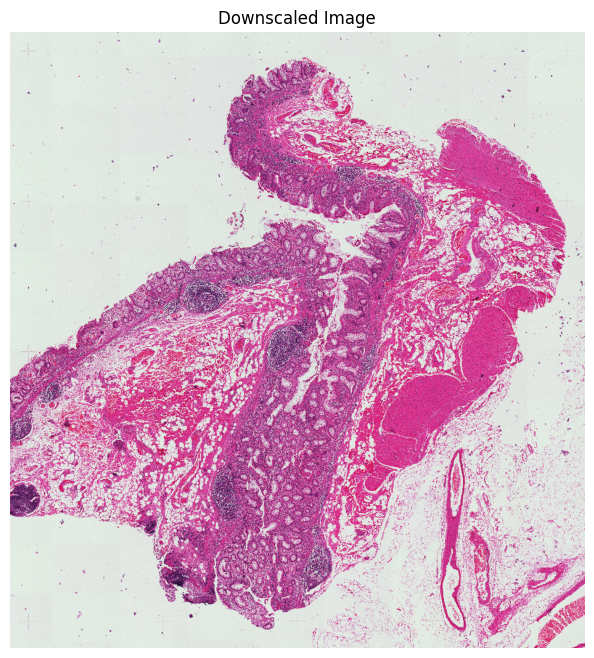

In [12]:
import matplotlib.pyplot as plt

# Extract the downscaled image
downscaled_img = st.adata.uns['spatial']['ST']['images']['downscaled_fullres']

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(downscaled_img)
plt.axis('off')
plt.title("Downscaled Image")
plt.show()

maybe the code is plotting fullres rather than downscaled
find the downscale factor for downscaling
the default for registerdownscale img spot size is 55, which is different from 100

In [13]:
# Check the keys in adata.uns["spatial"]
print("Keys in adata.uns['spatial']:", st.adata.uns['spatial'].keys())

# Inspect the ST slot
spatial_ST = st.adata.uns['spatial']['ST']
print("Keys in adata.uns['spatial']['ST']:", spatial_ST.keys())

# Images available
images = spatial_ST.get('images', {})
print("Images available:", list(images.keys()))
for k, v in images.items():
    print(f"  {k}: type={type(v)}, shape={getattr(v, 'shape', 'N/A')}")

# Scale factors
scalefactors = spatial_ST.get('scalefactors', {})
print("Scale factors available:", scalefactors)
for k, v in scalefactors.items():
    print(f"  {k}: {v}")


Keys in adata.uns['spatial']: dict_keys(['ST'])
Keys in adata.uns['spatial']['ST']: dict_keys(['images', 'scalefactors'])
Images available: ['downscaled_fullres']
  downscaled_fullres: type=<class 'numpy.ndarray'>, shape=(1000, 933, 3)
Scale factors available: {'spot_diameter_fullres': 258.8235294117647, 'tissue_downscaled_fullres_scalef': 0.017280707817792215}
  spot_diameter_fullres: 258.8235294117647
  tissue_downscaled_fullres_scalef: 0.017280707817792215


#### spot diameter fullres is double of that of our Xenium data (suspect it is because HE_registered is double the size of HE_original)

In [14]:
st.save(save_dir, pyramidal=True)

saving to pyramidal tiff... can be slow
